In [1]:
!pip install tensorflow_addons==0.9.1

     |████████████████████████████████| 1.0 MB 2.9 MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import gc
import os
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Multiply, Add, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def now():
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED = 1337
seed_everything(SEED)

In [3]:
# *************** PROCESSED DATASET ***************

df_train = pd.read_pickle('../input/ion-switching-preprocessing/train.pkl')
df_test = pd.read_pickle('../input/ion-switching-preprocessing/test.pkl')

df_train['is_filtered'] = df_train['is_filtered'].astype(np.uint8)
df_test.loc[df_test['model'] == 1.5, 'model'] = 2

for df in [df_train, df_test]:
    df['model'] = df['model'].astype(np.uint8) 
    df.drop(columns=['time', 'signal', 'time_scaled', 'signal_processed_kalman', 'batch'], inplace=True)
    
# *************** RFC MODEL PROBABILITIES ***************
rfc_proba_columns = [f'rfc_probability{i}' for i in range(11)]
y_train_rfc_proba = pd.DataFrame(np.load('../input/ion-shifted-rfc-proba/Y_train_proba.npy')).astype(np.float32)
y_test_rfc_proba = pd.DataFrame(np.load('../input/ion-shifted-rfc-proba/Y_test_proba.npy')).astype(np.float32)

for df in [y_train_rfc_proba, y_test_rfc_proba]:
    df.rename(columns={i: f'rfc_probability{i}' for i in range(11)}, inplace=True)

df_train = pd.concat([df_train, y_train_rfc_proba], axis=1)
df_test = pd.concat([df_test, y_test_rfc_proba], axis=1)

print(f'Training Set Shape = {df_train.shape}')
print(f'Training Set Memory Usage = {(df_train.memory_usage().sum() / 1024 ** 2):.2f} MB')
print(f'Test Set Shape = {df_test.shape}')
print(f'Test Set Memory Usage = {(df_test.memory_usage().sum() / 1024 ** 2):.2f} MB\n')

df_train['rfc_predictions'] = np.argmax(df_train[rfc_proba_columns].values, axis=1).astype(np.uint8)

for model in range(5):
    y_min = df_train.loc[df_train['model'] == model, 'open_channels'].min()
    y_max = df_train.loc[df_train['model'] == model, 'open_channels'].max()
    df_train.loc[df_train['model'] == model, 'rfc_predictions'] = np.clip(df_train.loc[df_train['model'] == model, 'rfc_predictions'], y_min, y_max)

print('RFC Model probabilities are added to dataset')
print('--------------------------------------------')

for model in range(5):    
    y_true = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    y_pred = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'rfc_predictions']
    print(f'RFC Model {model} OOF Macro F1-Score {f1_score(y_true, y_pred, average="macro"):.6}')    
print(f'RFC Model Global OOF Macro F1-Score {f1_score(df_train["open_channels"], df_train["rfc_predictions"], average="macro"):.6}')

df_train.drop(columns=['rfc_predictions'], inplace=True)

df_train['signal_processed'] = df_train['signal_processed_denoised']
df_test['signal_processed'] = df_test['signal_processed_denoised']

del y_train_rfc_proba, y_test_rfc_proba
gc.collect()

Training Set Shape = (5000000, 16)
Training Set Memory Usage = 262.26 MB
Test Set Shape = (2000000, 14)
Test Set Memory Usage = 101.09 MB

RFC Model probabilities are added to dataset
--------------------------------------------
RFC Model 0 OOF Macro F1-Score 0.997055
RFC Model 1 OOF Macro F1-Score 0.996975
RFC Model 2 OOF Macro F1-Score 0.983606
RFC Model 3 OOF Macro F1-Score 0.971486
RFC Model 4 OOF Macro F1-Score 0.762101
RFC Model Global OOF Macro F1-Score 0.93812


22

In [4]:
class MacroF1(Callback):
    
    def __init__(self, model, verbose_eval, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train = train_data[0]
        self.y_train = np.argmax(train_data[1], axis=2).reshape(-1)
        self.train_f1_scores = []
        self.train_losses = []
        
        self.X_val = validation_data[0]
        self.y_val = np.argmax(validation_data[1], axis=2).reshape(-1)
        self.val_f1_scores = [] 
        self.val_losses = []
        
        self.model = model
        self.verbose_eval = verbose_eval
                
    def on_epoch_end(self, epoch, logs):
        
        train_predictions = np.argmax(self.model.predict(self.X_train), axis=2).reshape(-1)  
        train_f1_score = f1_score(self.y_train, train_predictions, average='macro')
        self.train_f1_scores.append(train_f1_score)
        self.train_losses.append(logs['loss'])
        
        validation_predictions = np.argmax(self.model.predict(self.X_val), axis=2).reshape(-1)  
        validation_f1_score = f1_score(self.y_val, validation_predictions, average='macro')
        self.val_f1_scores.append(validation_f1_score)
        self.val_losses.append(logs['val_loss'])
            
        logs['f1'] = train_f1_score
        logs['val_f1'] = validation_f1_score
        
        if (epoch % self.verbose_eval) == 0:
            print(f'[{now()}] Epoch: {epoch + 1} - loss: {logs["loss"]:.6} - accuracy: {logs["accuracy"]:.6} - f1: {logs["f1"]:.6} - val_loss: {logs["val_loss"]:.6} - val_accuracy: {logs["val_accuracy"]:.6} - val_f1: {logs["val_f1"]:.6}')

        
class WaveNet:
    
    def __init__(self, model_type, epochs, lr, lr_schedule, early_stopping_criteria, early_stopping_patience, batch_size, timesteps, verbose_eval):
                
        self.K = 2
        self.kf = None
        
        self.model_type = model_type
        self.epochs = epochs
        self.lr = lr
        self.lr_schedule = lr_schedule
        self.early_stopping_criteria = early_stopping_criteria
        self.early_stopping_patience = early_stopping_patience
        self.batch_size = batch_size
        self.timesteps = timesteps
        self.verbose_eval = verbose_eval
        
        self.logs = []
                        
    def cbr(self, X, output_layer, kernel_size, strides, dilation_rate):
        X = Conv1D(output_layer, kernel_size=kernel_size, dilation_rate=dilation_rate, strides=strides, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        return X
    
    def wave_block(self, X, filters, kernel_size, n):
        
        X = Conv1D(filters=filters, kernel_size=1, padding='same')(X)        
        res_X = X
        
        dilation_rates = [2 ** i for i in range(n)]
        
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='tanh', dilation_rate=dilation_rate)(X)
            sigmoid_out = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='sigmoid', dilation_rate=dilation_rate)(X)
            X = Multiply()([tanh_out, sigmoid_out])
            X = Conv1D(filters=filters, kernel_size=1, padding='same')(X)
            res_X = Add()([res_X, X])
            
        return res_X
    
    def get_model(self, input_shape, output_shape, sample_weight_mode): 

        input_layer = Input(shape=(input_shape))
        X = self.cbr(input_layer, 64, 7, 1, 1)
        X = BatchNormalization()(X)
        X = self.wave_block(X, 16, 3, 12)
        X = BatchNormalization()(X)
        X = self.wave_block(X, 32, 3, 8)
        X = BatchNormalization()(X)
        X = self.wave_block(X, 64, 3, 4)
        X = BatchNormalization()(X)
        X = self.wave_block(X, 128, 3, 1)
        X = self.cbr(X, 32, 7, 1, 1)
        X = BatchNormalization()(X)
        X = Dropout(0.25)(X)
        output_layer = Dense(output_shape, activation='softmax', name='output')(X)

        model = Model(inputs=input_layer, outputs=output_layer)
        optimizer = Adam(lr=self.lr)
        optimizer = tfa.optimizers.SWA(optimizer)

        model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'], sample_weight_mode=sample_weight_mode)
        return model
                        
    def train_and_predict(self, X_train, X_test):
        
        K.clear_session()
        seed_everything(SEED)
        config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        session = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
        tf.compat.v1.keras.backend.set_session(session)
                                
        unique_openchannels = X_train['open_channels'].nunique()
        
        self.scores = []
        self.oof = np.zeros((X_train.shape[0], unique_openchannels))
        self.y_pred = np.zeros((X_test.shape[0], unique_openchannels))
        
        model_count = X_train['model'].nunique()
        models = X_train['model'].unique().tolist()
        if model_count <= 1:
            self.kf = KFold(n_splits=self.K)
        else:
            self.kf = StratifiedKFold(n_splits=self.K)
            
        print(f'[{now()}] Running WaveNet {self.model_type.capitalize()} Model with {self.K}K {(self.kf.__class__.__name__)}')
                        
        for df in [X_train, X_test]:
            df['group'] = df.groupby(df.index // self.timesteps, sort=False)['signal_processed'].agg(['ngroup']).values
            df['group'] = df['group'].astype(np.uint16)
            
        mu = pd.concat([X_train.loc[df_train['is_filtered'] == 0, 'signal_processed'], X_test['signal_processed']], axis=0).mean()
        sigma = pd.concat([X_train.loc[df_train['is_filtered'] == 0, 'signal_processed'], X_test['signal_processed']], axis=0).std()
        X_train['signal_processed'] = (X_train['signal_processed'] - mu) / sigma
        X_test['signal_processed'] = (X_test['signal_processed'] - mu) / sigma
            
        target_cols = [i for i in range(unique_openchannels)]
        if self.model_type == 'solo':
            feature_cols = [col for col in X_train.columns.tolist() if col != 'open_channels' and col != 'group' and col != 'model' and col != 'is_filtered']
        else:
            feature_cols = [col for col in X_train.columns.tolist() if col != 'open_channels' and col != 'group' and col != 'is_filtered']
            
        X_train = pd.concat([X_train, pd.get_dummies(X_train['open_channels'])], axis=1).drop(columns=['open_channels'])
        X_test_reshaped = np.array(list(X_test.groupby('group').apply(lambda x: x[feature_cols].values)))
                                 
        for fold, (trn_idx, val_idx) in enumerate(self.kf.split(X_train, X_train['model']), 1):
            print(f'\nFold {fold}\n') 
            
            X_trn = X_train.iloc[trn_idx]
            X_val = X_train.iloc[val_idx]
            
            y_trn_reshaped = np.array(list(X_trn.groupby('group').apply(lambda x: x[target_cols].values)))
            y_val_reshaped = np.array(list(X_val.groupby('group').apply(lambda x: x[target_cols].values)))
            X_trn_reshaped = np.array(list(X_trn.groupby('group').apply(lambda x: x[feature_cols].values)))
            X_val_reshaped = np.array(list(X_val.groupby('group').apply(lambda x: x[feature_cols].values)))
            print(f'[{now()}] Training on {X_trn_reshaped.shape} - Validating on {X_val_reshaped.shape} - {y_val_reshaped.shape[2]} Class Classification')
            
            if 'is_filtered' in X_train.columns.tolist():
                filtered_idx = X_train[X_train['is_filtered'] == 1].index
                X_train['is_filtered'] = 1
                X_train.loc[filtered_idx, 'is_filtered'] = 0.005
                sample_weight = X_train.iloc[trn_idx]['is_filtered'].values.reshape(-1, self.timesteps)
                sample_weight_mode = 'temporal'
            else:
                sample_weight = None
                sample_weight_mode = None
                                                                                                 
            model = self.get_model((None, X_trn_reshaped.shape[2]), y_trn_reshaped.shape[2], sample_weight_mode)
            lr_schedule = LearningRateScheduler(self.lr_schedule)
            
            if self.early_stopping_criteria == 'val_loss':
                early_stopping_mode = 'min'
            elif self.early_stopping_criteria == 'val_f1':
                early_stopping_mode = 'max'
            else:
                early_stopping_mode = 'auto'
                
            es = EarlyStopping(monitor=self.early_stopping_criteria, mode=early_stopping_mode, restore_best_weights=True, verbose=2, patience=self.early_stopping_patience)
            custom_metric = MacroF1(model, self.verbose_eval, train_data=(X_trn_reshaped, y_trn_reshaped), validation_data=(X_val_reshaped, y_val_reshaped))
            model.fit(X_trn_reshaped, y_trn_reshaped, epochs=self.epochs, callbacks=[lr_schedule, custom_metric, es], batch_size=self.batch_size, verbose=0, sample_weight=sample_weight, validation_data=(X_val_reshaped, y_val_reshaped))
            self.logs.append(custom_metric)
            
            oof_predictions = model.predict(X_val_reshaped).reshape(-1, y_trn_reshaped.shape[2])
            for open_channel in range(unique_openchannels):
                self.oof[val_idx, open_channel] = oof_predictions[:, open_channel]
                
            test_predictions = model.predict(X_test_reshaped).reshape(-1, y_trn_reshaped.shape[2])
            self.y_pred += test_predictions / self.K
            
            score = f1_score(np.argmax(y_val_reshaped, axis=2).reshape(-1),  np.argmax(oof_predictions, axis=1), average='macro')
            self.scores.append(score)
            print('\nSolo WaveNet Fold {} Macro F1-Score {}\n'.format(fold, score))
            
            del X_trn, X_val, X_trn_reshaped, y_trn_reshaped, X_val_reshaped, y_val_reshaped
            del model, lr_schedule, es, custom_metric, oof_predictions, test_predictions, score
            gc.collect()
            
        for open_channel in range(unique_openchannels):
            df_train.loc[X_train.index, f'wavenet_{self.model_type}_model_probability{open_channel}'] = self.oof[:, open_channel]
            df_test.loc[X_test.index, f'wavenet_{self.model_type}_model_probability{open_channel}'] = self.y_pred[:, open_channel]
        
        del X_test, X_test_reshaped, self.y_pred
        gc.collect()
        
        print('--------------------')
        print(f'{self.model_type.capitalize()} WaveNet Mean Macro F1-Score {np.mean(self.scores):.6} [STD:{np.std(self.scores):.6}]')
        probability_columns = [f'wavenet_{self.model_type}_model_probability{i}' for i in range(unique_openchannels)]
        for model in models:
            model_oof = np.argmax(df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), probability_columns].values, axis=1)
            model_labels = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
            print(f'{self.model_type.capitalize()} WaveNet Model {model} OOF Macro F1-Score {f1_score(model_labels, np.clip(model_oof, np.min(model_labels), np.max(model_labels)), average="macro"):.6}')
            del model_oof, model_labels
        global_model_labels = df_train.loc[X_train.index]['open_channels']
        print(f'{self.model_type.capitalize()} WaveNet OOF Macro F1-Score {f1_score(global_model_labels, np.round(np.clip(np.argmax(self.oof, axis=1), global_model_labels.min(), global_model_labels.max())), average="macro"):.6}')
        print('--------------------')
        del global_model_labels, X_train, self.oof
        gc.collect()
        
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=self.K, ncols=2, figsize=(20, 12), dpi=100)

        for i in range(self.K):
            
            sns.lineplot(x=np.arange(1, len(self.logs[i].train_f1_scores) + 1), y=self.logs[i].train_f1_scores, ax=axes[i][0], label='Train F1 Score')
            sns.lineplot(x=np.arange(1, len(self.logs[i].val_f1_scores) + 1), y=self.logs[i].val_f1_scores, ax=axes[i][0], label='Validation F1 Score')        

            axes[i][0].legend() 
            axes[i][0].set_title(f'Fold {i} Train and Validation F1 Scores', fontsize=14)

            sns.lineplot(x=np.arange(1, len(self.logs[i].train_losses) + 1), y=self.logs[i].train_losses, ax=axes[i][1], label='Train Loss')
            sns.lineplot(x=np.arange(1, len(self.logs[i].val_losses) + 1), y=self.logs[i].val_losses, ax=axes[i][1], label='Validation Loss')

            axes[i][1].legend() 
            axes[i][1].set_title(f'Fold {i} Train and Validation Losses', fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()

[2020-05-16 10:11:43] Running WaveNet Penta Model with 2K StratifiedKFold

Fold 1

[2020-05-16 10:12:24] Training on (6250, 400, 13) - Validating on (6250, 400, 13) - 11 Class Classification
[2020-05-16 10:13:41] Epoch: 1 - loss: 0.366245 - accuracy: 0.914987 - f1: 0.930129 - val_loss: 0.155161 - val_accuracy: 0.967852 - val_f1: 0.93348
[2020-05-16 10:14:18] Epoch: 2 - loss: 0.164079 - accuracy: 0.963154 - f1: 0.936346 - val_loss: 0.111357 - val_accuracy: 0.969762 - val_f1: 0.938417
[2020-05-16 10:14:54] Epoch: 3 - loss: 0.140837 - accuracy: 0.965254 - f1: 0.937633 - val_loss: 0.103608 - val_accuracy: 0.969996 - val_f1: 0.939073
[2020-05-16 10:15:30] Epoch: 4 - loss: 0.128612 - accuracy: 0.966377 - f1: 0.938615 - val_loss: 0.0983369 - val_accuracy: 0.97018 - val_f1: 0.93952
[2020-05-16 10:16:07] Epoch: 5 - loss: 0.12006 - accuracy: 0.967212 - f1: 0.939313 - val_loss: 0.0939592 - val_accuracy: 0.970357 - val_f1: 0.939809
[2020-05-16 10:16:42] Epoch: 6 - loss: 0.114262 - accuracy: 0.9676

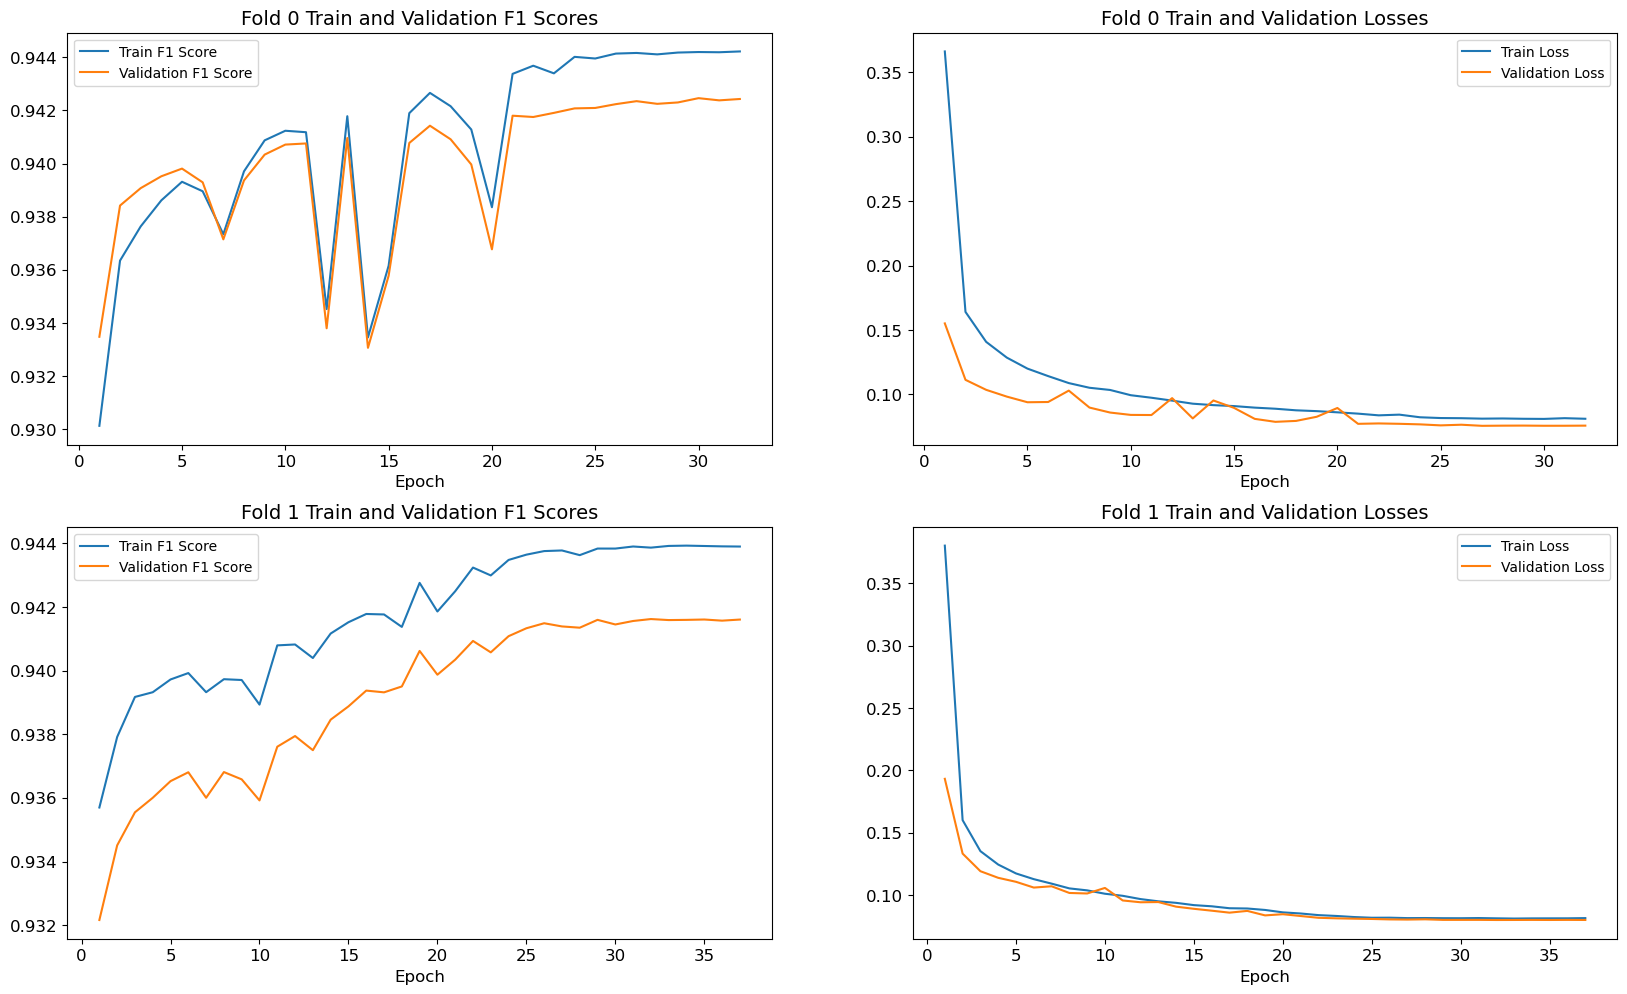

676856

In [5]:
proba_columns = [f'rfc_probability{i}' for i in range(11)]
penta_model_X_train = df_train[(['signal_processed', 'open_channels', 'model'] + proba_columns)].copy(deep=True)
penta_model_X_test = df_test[(['signal_processed', 'model'] + proba_columns)].copy(deep=True)

initial_lr = 0.0002

'''
Penta WaveNet Model 0 OOF Macro F1-Score 0.99728
Penta WaveNet Model 1 OOF Macro F1-Score 0.997084
Penta WaveNet Model 2 OOF Macro F1-Score 0.984043
Penta WaveNet Model 4 OOF Macro F1-Score 0.78673
Penta WaveNet Model 3 OOF Macro F1-Score 0.972353
Penta WaveNet OOF Macro F1-Score 0.941987
'''

def lr_schedule(epoch, initial_lr=initial_lr):    
    if epoch < 20:
        lr = initial_lr
    elif epoch < 30:
        lr = initial_lr / 1.5
        if epoch == 20:
            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')
    elif epoch < 35:
        lr = initial_lr / 1.75
        if epoch == 30:
            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')
    elif epoch < 40:
        lr = initial_lr / 2
        if epoch == 35:
            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')
    elif epoch < 45:
        lr = initial_lr / 2.5
        if epoch == 40:
            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')
    elif epoch < 50:
        lr = initial_lr / 3
        if epoch == 45:
            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')
    elif epoch < 55:
        lr = initial_lr / 4
        if epoch == 50:
            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')
    else:
        lr = initial_lr / 5
        if epoch == 55:
            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')
    return lr
        
wavenet_penta_model_parameters = {
    'model_type': 'penta',
    'epochs': 55,
    'lr': initial_lr,
    'lr_schedule': lr_schedule,
    'early_stopping_criteria': 'val_loss',
    'early_stopping_patience': 5,
    'batch_size': 2 ** 4,
    'timesteps': 400,
    'verbose_eval': 1
}

wavenet_penta_model = WaveNet(wavenet_penta_model_parameters['model_type'],
                              wavenet_penta_model_parameters['epochs'],
                              wavenet_penta_model_parameters['lr'],
                              wavenet_penta_model_parameters['lr_schedule'],
                              wavenet_penta_model_parameters['early_stopping_criteria'],
                              wavenet_penta_model_parameters['early_stopping_patience'],
                              wavenet_penta_model_parameters['batch_size'], 
                              wavenet_penta_model_parameters['timesteps'],
                              wavenet_penta_model_parameters['verbose_eval'])

wavenet_penta_model.train_and_predict(penta_model_X_train, penta_model_X_test)
wavenet_penta_model.plot_learning_curve()

del penta_model_X_train, penta_model_X_test, wavenet_penta_model_parameters, wavenet_penta_model
gc.collect()

In [6]:
wavenet_proba_columns = [f'wavenet_penta_model_probability{i}' for i in range(11)]
df_train['wavenet_penta_model_predictions'] = np.argmax(df_train[wavenet_proba_columns].fillna(0).values, axis=1).astype(np.uint8)
df_test['wavenet_penta_model_predictions'] = np.argmax(df_test[wavenet_proba_columns].fillna(0).values, axis=1).astype(np.uint8)

for df in [df_train, df_test]:
    df.loc[df['model'] == 0, 'wavenet_penta_model_predictions'] = np.clip(df.loc[df['model'] == 0, 'wavenet_penta_model_predictions'], 0, 1)
    df.loc[df['model'] == 1, 'wavenet_penta_model_predictions'] = np.clip(df.loc[df['model'] == 1, 'wavenet_penta_model_predictions'], 0, 1)
    df.loc[df['model'] == 2, 'wavenet_penta_model_predictions'] = np.clip(df.loc[df['model'] == 2, 'wavenet_penta_model_predictions'], 0, 3)
    df.loc[df['model'] == 3, 'wavenet_penta_model_predictions'] = np.clip(df.loc[df['model'] == 3, 'wavenet_penta_model_predictions'], 0, 5)
    df.loc[df['model'] == 4, 'wavenet_penta_model_predictions'] = np.clip(df.loc[df['model'] == 4, 'wavenet_penta_model_predictions'], 0, 10)

print('#################### MODEL EVALUATION ####################')
print('----------------------------------------------------------')

for model in range(5):    
    y_true = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    y_pred = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'wavenet_penta_model_predictions']
    
    print(f'WaveNet Model {model} OOF Macro F1-Score {f1_score(y_true, np.clip(y_pred, y_true.min(), y_true.max()), average="macro"):.6}')
    
print(f'\n########## Model Global ##########')
print('----------------------------------')

global_y_true = df_train.loc[df_train['is_filtered'] == 0, 'open_channels']
global_y_pred = df_train.loc[df_train['is_filtered'] == 0, 'wavenet_penta_model_predictions']

print(f'WaveNet Model Global OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.clip(global_y_pred, global_y_true.min(), global_y_true.max()), average="macro"):.6}')

#################### MODEL EVALUATION ####################
----------------------------------------------------------
WaveNet Model 0 OOF Macro F1-Score 0.99728
WaveNet Model 1 OOF Macro F1-Score 0.997086
WaveNet Model 2 OOF Macro F1-Score 0.984048
WaveNet Model 3 OOF Macro F1-Score 0.972438
WaveNet Model 4 OOF Macro F1-Score 0.787179

########## Model Global ##########
----------------------------------
WaveNet Model Global OOF (Rounded) Macro F1-Score 0.942081


In [7]:
submission = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv')
submission['open_channels'] = df_test['wavenet_penta_model_predictions'].copy()
submission.to_csv('wavenet_submission.csv', index=False, float_format='%.4f')
print(f'WaveNet Penta Model Submission\n\n{submission["open_channels"].describe()}')

WaveNet Penta Model Submission

count    2.000000e+06
mean     1.381452e+00
std      2.321165e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      1.000000e+01
Name: open_channels, dtype: float64


In [8]:
'''solo_model_X_train = df_train[df_train['model'] == 0][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1']].copy(deep=True)
solo_model_X_test = df_test[df_test['model'] == 0][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1']].copy(deep=True)

initial_lr = 0.0005

def lr_schedule(epoch, initial_lr=initial_lr):    
    lr = initial_lr
    return lr
        
wavenet_solo_model_parameters = {
    'model_type': 'solo',
    'epochs': 18,
    'lr': initial_lr,
    'lr_schedule': lr_schedule,
    'early_stopping_criteria': 'val_loss',
    'early_stopping_patience': 3,
    'batch_size': 2 ** 4,
    'timesteps': 500,
    'verbose_eval': 1
}

wavenet_solomodel = WaveNet(wavenet_solo_model_parameters['model_type'],
                            wavenet_solo_model_parameters['epochs'],
                            wavenet_solo_model_parameters['lr'],
                            wavenet_solo_model_parameters['lr_schedule'],
                            wavenet_solo_model_parameters['early_stopping_criteria'],
                            wavenet_solo_model_parameters['early_stopping_patience'],
                            wavenet_solo_model_parameters['batch_size'], 
                            wavenet_solo_model_parameters['timesteps'],
                            wavenet_solo_model_parameters['verbose_eval'])

wavenet_solomodel.train_and_predict(solo_model_X_train, solo_model_X_test)
wavenet_solomodel.plot_learning_curve()

del solo_model_X_train, solo_model_X_test, wavenet_solo_model_parameters, wavenet_solomodel'''

"solo_model_X_train = df_train[df_train['model'] == 0][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1']].copy(deep=True)\nsolo_model_X_test = df_test[df_test['model'] == 0][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1']].copy(deep=True)\n\ninitial_lr = 0.0005\n\ndef lr_schedule(epoch, initial_lr=initial_lr):    \n    lr = initial_lr\n    return lr\n        \nwavenet_solo_model_parameters = {\n    'model_type': 'solo',\n    'epochs': 18,\n    'lr': initial_lr,\n    'lr_schedule': lr_schedule,\n    'early_stopping_criteria': 'val_loss',\n    'early_stopping_patience': 3,\n    'batch_size': 2 ** 4,\n    'timesteps': 500,\n    'verbose_eval': 1\n}\n\nwavenet_solomodel = WaveNet(wavenet_solo_model_parameters['model_type'],\n                            wavenet_solo_model_parameters['epochs'],\n                            wavenet_solo_model_parameters['lr'],\n                            wavenet_solo_model_parameters['lr_schedule'],\

In [9]:
'''solo_model_X_train = df_train[df_train['model'] == 1][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1']].copy(deep=True)
solo_model_X_test = df_test[df_test['model'] == 1][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1']].copy(deep=True)

initial_lr = 0.0005

def lr_schedule(epoch, initial_lr=initial_lr):    
    lr = initial_lr
    return lr
        
wavenet_solo_model_parameters = {
    'model_type': 'solo',
    'epochs': 18,
    'lr': initial_lr,
    'lr_schedule': lr_schedule,
    'early_stopping_criteria': 'val_loss',
    'early_stopping_patience': 3,
    'batch_size': 2 ** 4,
    'timesteps': 500,
    'verbose_eval': 1
}

wavenet_solomodel = WaveNet(wavenet_solo_model_parameters['model_type'],
                            wavenet_solo_model_parameters['epochs'],
                            wavenet_solo_model_parameters['lr'],
                            wavenet_solo_model_parameters['lr_schedule'],
                            wavenet_solo_model_parameters['early_stopping_criteria'],
                            wavenet_solo_model_parameters['early_stopping_patience'],
                            wavenet_solo_model_parameters['batch_size'], 
                            wavenet_solo_model_parameters['timesteps'],
                            wavenet_solo_model_parameters['verbose_eval'])

wavenet_solomodel.train_and_predict(solo_model_X_train, solo_model_X_test)
wavenet_solomodel.plot_learning_curve()

del solo_model_X_train, solo_model_X_test, wavenet_solo_model_parameters, wavenet_solomodel'''

"solo_model_X_train = df_train[df_train['model'] == 1][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1']].copy(deep=True)\nsolo_model_X_test = df_test[df_test['model'] == 1][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1']].copy(deep=True)\n\ninitial_lr = 0.0005\n\ndef lr_schedule(epoch, initial_lr=initial_lr):    \n    lr = initial_lr\n    return lr\n        \nwavenet_solo_model_parameters = {\n    'model_type': 'solo',\n    'epochs': 18,\n    'lr': initial_lr,\n    'lr_schedule': lr_schedule,\n    'early_stopping_criteria': 'val_loss',\n    'early_stopping_patience': 3,\n    'batch_size': 2 ** 4,\n    'timesteps': 500,\n    'verbose_eval': 1\n}\n\nwavenet_solomodel = WaveNet(wavenet_solo_model_parameters['model_type'],\n                            wavenet_solo_model_parameters['epochs'],\n                            wavenet_solo_model_parameters['lr'],\n                            wavenet_solo_model_parameters['lr_schedule'],\

In [10]:
'''solo_model_X_train = df_train[df_train['model'] == 2][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'is_filtered']].copy(deep=True)
solo_model_X_test = df_test[df_test['model'] == 2][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3']].copy(deep=True)
    
initial_lr = 0.0003  
       
def lr_schedule(epoch, initial_lr=initial_lr):    
    lr = initial_lr
    return lr
        
wavenet_solo_model_parameters = {
    'model_type': 'solo',
    'epochs': 12,
    'lr': initial_lr,
    'lr_schedule': lr_schedule,
    'early_stopping_criteria': 'val_loss',
    'early_stopping_patience': 10,
    'batch_size': 2 ** 4,
    'timesteps': 250,
    'verbose_eval': 1
}

wavenet_solomodel = WaveNet(wavenet_solo_model_parameters['model_type'],
                            wavenet_solo_model_parameters['epochs'],
                            wavenet_solo_model_parameters['lr'],
                            wavenet_solo_model_parameters['lr_schedule'],
                            wavenet_solo_model_parameters['early_stopping_criteria'],
                            wavenet_solo_model_parameters['early_stopping_patience'],
                            wavenet_solo_model_parameters['batch_size'], 
                            wavenet_solo_model_parameters['timesteps'],
                            wavenet_solo_model_parameters['verbose_eval'])

wavenet_solomodel.train_and_predict(solo_model_X_train, solo_model_X_test)
wavenet_solomodel.plot_learning_curve()

del solo_model_X_train, solo_model_X_test, wavenet_solo_model_parameters, wavenet_solomodel'''

"solo_model_X_train = df_train[df_train['model'] == 2][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'is_filtered']].copy(deep=True)\nsolo_model_X_test = df_test[df_test['model'] == 2][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3']].copy(deep=True)\n    \ninitial_lr = 0.0003  \n       \ndef lr_schedule(epoch, initial_lr=initial_lr):    \n    lr = initial_lr\n    return lr\n        \nwavenet_solo_model_parameters = {\n    'model_type': 'solo',\n    'epochs': 12,\n    'lr': initial_lr,\n    'lr_schedule': lr_schedule,\n    'early_stopping_criteria': 'val_loss',\n    'early_stopping_patience': 10,\n    'batch_size': 2 ** 4,\n    'timesteps': 250,\n    'verbose_eval': 1\n}\n\nwavenet_solomodel = WaveNet(wavenet_solo_model_parameters['model_type'],\n                            wavenet_solo_model_parameters['epochs'],\n                            wav

In [11]:
'''solo_model_X_train = df_train[df_train['model'] == 3][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'rfc_probability4', 'rfc_probability5']].copy(deep=True)
solo_model_X_test = df_test[df_test['model'] == 3][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'rfc_probability4', 'rfc_probability5']].copy(deep=True)

initial_lr = 0.0005  

def lr_schedule(epoch, initial_lr=initial_lr):    
    lr = initial_lr
    return lr
        
wavenet_solo_model_parameters = {
    'model_type': 'solo',
    'epochs': 15,
    'lr': initial_lr,
    'lr_schedule': lr_schedule,
    'early_stopping_criteria': 'val_loss',
    'early_stopping_patience': 5,
    'batch_size': 2 ** 4,
    'timesteps': 500,
    'verbose_eval': 1
}

wavenet_solomodel = WaveNet(wavenet_solo_model_parameters['model_type'],
                            wavenet_solo_model_parameters['epochs'],
                            wavenet_solo_model_parameters['lr'],
                            wavenet_solo_model_parameters['lr_schedule'],
                            wavenet_solo_model_parameters['early_stopping_criteria'],
                            wavenet_solo_model_parameters['early_stopping_patience'],
                            wavenet_solo_model_parameters['batch_size'], 
                            wavenet_solo_model_parameters['timesteps'],
                            wavenet_solo_model_parameters['verbose_eval'])

wavenet_solomodel.train_and_predict(solo_model_X_train, solo_model_X_test)
wavenet_solomodel.plot_learning_curve()

del solo_model_X_train, solo_model_X_test, wavenet_solo_model_parameters, wavenet_solomodel'''

"solo_model_X_train = df_train[df_train['model'] == 3][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'rfc_probability4', 'rfc_probability5']].copy(deep=True)\nsolo_model_X_test = df_test[df_test['model'] == 3][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'rfc_probability4', 'rfc_probability5']].copy(deep=True)\n\ninitial_lr = 0.0005  \n\ndef lr_schedule(epoch, initial_lr=initial_lr):    \n    lr = initial_lr\n    return lr\n        \nwavenet_solo_model_parameters = {\n    'model_type': 'solo',\n    'epochs': 15,\n    'lr': initial_lr,\n    'lr_schedule': lr_schedule,\n    'early_stopping_criteria': 'val_loss',\n    'early_stopping_patience': 5,\n    'batch_size': 2 ** 4,\n    'timesteps': 500,\n    'verbose_eval': 1\n}\n\nwavenet_solomodel = WaveNet(wavenet_solo_model_parameters['model_type'],\n                            wavenet_solo_model_p

In [12]:
'''solo_model_X_train = df_train[df_train['model'] == 4][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'rfc_probability4', 'rfc_probability5', 'rfc_probability6', 'rfc_probability7', 'rfc_probability8', 'rfc_probability9', 'rfc_probability10']].copy(deep=True)
solo_model_X_test = df_test[df_test['model'] == 4][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'rfc_probability4', 'rfc_probability5', 'rfc_probability6', 'rfc_probability7', 'rfc_probability8', 'rfc_probability9', 'rfc_probability10']].copy(deep=True)

def lr_schedule(epoch, initial_lr=0.0005):    
    if epoch < 20:
        lr = initial_lr
    elif epoch < 30:
        lr = initial_lr / 1.5
        if epoch == 20:
            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')
    elif epoch < 40:
        if epoch == 30:
            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')
        lr = initial_lr / 2
    return lr
        
wavenet_solo_model_parameters = {
    'model_type': 'solo',
    'epochs': 20,
    'lr': 0.0001,
    'lr_schedule': lr_schedule,
    'early_stopping_criteria': 'val_loss',
    'early_stopping_patience': 5,
    'batch_size': 2 ** 4,
    'timesteps': 500,
    'verbose_eval': 1
}

wavenet_solomodel = WaveNet(wavenet_solo_model_parameters['model_type'],
                            wavenet_solo_model_parameters['epochs'],
                            wavenet_solo_model_parameters['lr'],
                            wavenet_solo_model_parameters['lr_schedule'],
                            wavenet_solo_model_parameters['early_stopping_criteria'],
                            wavenet_solo_model_parameters['early_stopping_patience'],
                            wavenet_solo_model_parameters['batch_size'], 
                            wavenet_solo_model_parameters['timesteps'],
                            wavenet_solo_model_parameters['verbose_eval'])

wavenet_solomodel.train_and_predict(solo_model_X_train, solo_model_X_test)
wavenet_solomodel.plot_learning_curve()

del solo_model_X_train, solo_model_X_test, wavenet_solo_model_parameters, wavenet_solomodel'''

"solo_model_X_train = df_train[df_train['model'] == 4][['signal_processed', 'open_channels', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'rfc_probability4', 'rfc_probability5', 'rfc_probability6', 'rfc_probability7', 'rfc_probability8', 'rfc_probability9', 'rfc_probability10']].copy(deep=True)\nsolo_model_X_test = df_test[df_test['model'] == 4][['signal_processed', 'model', 'rfc_probability0', 'rfc_probability1', 'rfc_probability2', 'rfc_probability3', 'rfc_probability4', 'rfc_probability5', 'rfc_probability6', 'rfc_probability7', 'rfc_probability8', 'rfc_probability9', 'rfc_probability10']].copy(deep=True)\n\ndef lr_schedule(epoch, initial_lr=0.0005):    \n    if epoch < 20:\n        lr = initial_lr\n    elif epoch < 30:\n        lr = initial_lr / 1.5\n        if epoch == 20:\n            print(f'[{now()}] Learning rate has changed from {initial_lr:.6} to {lr:.6}')\n    elif epoch < 40:\n        if epoch == 30:\n            print(f'[{now()}

In [13]:
'''wavenet_solo_proba_columns = [f'wavenet_solo_model_probability{i}' for i in range(11)]
df_train['wavenet_solo_model_predictions'] = np.argmax(df_train[wavenet_solo_proba_columns].fillna(0).values, axis=1)

print('#################### SOLO MODEL EVALUATION ####################')
print('---------------------------------------------------------------')

for model in range(5):    
    y_true = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    y_pred = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'wavenet_solo_model_predictions']
    
    print(f'WaveNet Solo Model {model} OOF Macro F1-Score {f1_score(y_true, np.clip(y_pred, y_true.min(), y_true.max()), average="macro"):.6}')
    
print(f'\n########## Solo Model Global ##########')
print('---------------------------------------')

global_y_true = df_train.loc[df_train['is_filtered'] == 0, 'open_channels']
global_y_pred = df_train.loc[df_train['is_filtered'] == 0, 'wavenet_solo_model_predictions']

print(f'Solo LGB Model Global OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.clip(global_y_pred, global_y_true.min(), global_y_true.max()), average="macro"):.6}')'''

'wavenet_solo_proba_columns = [f\'wavenet_solo_model_probability{i}\' for i in range(11)]\ndf_train[\'wavenet_solo_model_predictions\'] = np.argmax(df_train[wavenet_solo_proba_columns].fillna(0).values, axis=1)\n\nprint(\'#################### SOLO MODEL EVALUATION ####################\')\nprint(\'---------------------------------------------------------------\')\n\nfor model in range(5):    \n    y_true = df_train.loc[(df_train[\'model\'] == model) & (df_train[\'is_filtered\'] == 0), \'open_channels\']\n    y_pred = df_train.loc[(df_train[\'model\'] == model) & (df_train[\'is_filtered\'] == 0), \'wavenet_solo_model_predictions\']\n    \n    print(f\'WaveNet Solo Model {model} OOF Macro F1-Score {f1_score(y_true, np.clip(y_pred, y_true.min(), y_true.max()), average="macro"):.6}\')\n    \nprint(f\'\n########## Solo Model Global ##########\')\nprint(\'---------------------------------------\')\n\nglobal_y_true = df_train.loc[df_train[\'is_filtered\'] == 0, \'open_channels\']\nglobal_y_pre